<a href="https://colab.research.google.com/github/art-glazunov/MegaFon_RecSys_Workshop/blob/main/Part_6_3_DSSM_recommender_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MegaFon RecSys workshop
by Artyom Glazunov

## Part 6.3. DSSM recommender embeddings

## The plan

- ### Data and model loading
- ### Useful classes and methods
- ### Some preparations...
- ### Embeddings plot
  - #### T-SNE method
  - #### UMAP method

In [ ]:
pip install -q lightfm==1.16

In [ ]:
pip install umap-learn -q

In [ ]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import umap

from keras.models import load_model

from lightfm import data

import seaborn as sns
import matplotlib.pyplot as plt

import copy
import warnings
import gc

### Data and model loading

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest_22/data

/content/drive/MyDrive/Colab_Notebooks/datafest_22/data


In [ ]:
data_train_all = pd.read_csv("train.csv")
data_train_pos = pd.read_csv("train_pos.csv")
cold_items_data = pd.read_csv("cold_items_data.csv")

### Let's load a simple cnn dssm model trained WITHOUT item identity feature (v1 pipe). This model shows the best pictures.

In [ ]:
model = load_model("../models/cnn_model.h5", custom_objects={"triplet_loss": None})
model.summary()

Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 u2v_model (Sequential)         (None, 200)          7700000     ['input_4[0][0]']                
                                                                                           

Extract the items model

In [ ]:
model.layers[-2].name

'i2v_model'

In [ ]:
i2v = model.layers[-2]
i2v.summary()

Model: "i2v_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i2v_embeddings (Embedding)  (None, 4, 300)            19273500  
                                                                 
 i2v_conv_layer (Conv1D)     (None, 3, 600)            360600    
                                                                 
 i2v_pooling_layer (MaxPooli  (None, 1, 600)           0         
 ng1D)                                                           
                                                                 
 i2v_reshape (Flatten)       (None, 600)               0         
                                                                 
 i2v_output_layer (Dense)    (None, 200)               120200    
                                                                 
Total params: 19,754,300
Trainable params: 19,754,300
Non-trainable params: 0
_____________________________________________

### Useful classes and methods

In [ ]:
class ColumnCategorizer(TransformerMixin, BaseEstimator):
    """Creates new categorical features using continuous columns
    
    Requires 
    - quantiles list
    - columns to transform
    - new columns names
    """
    

    def __init__(self, qs, new_columns, old_columns):
        self.qs = qs #quantile list
        self.new_columns = new_columns #columns to create
        self.old_columns = old_columns #initial continuous columns
        self.transformers = {} #transformers storage
        

    def fit(self, X, y=None):
        """Fit transformers on a part of the columns
        X - train data
        """
        
        for column in self.old_columns:
            bins = np.unique([X[column].quantile(q=q) for q in self.qs])
            labels = [f"{column}_bin_{l_edge}_{r_edge}" for (l_edge, r_edge) in zip(bins[:-1], bins[1:])]
            self.transformers[column] = sklearn.preprocessing.FunctionTransformer(
                                             pd.cut, kw_args={'bins': bins, 
                                                              'include_lowest': True,
                                                              'labels': labels, 
                                                              'retbins': False}
                                                              ) 
            self.transformers[column].fit(X[column])
        return self
    

    def transform(self, X):
        """Transform data and return Pandas DataFrame
        X - data to transform
        """
        
        data_new = X.copy()
        for column_old, column_new in zip(self.old_columns, self.new_columns):
            data_new[column_new] = self.transformers[column_old].transform(data_new[column_old]).values
        return data_new


def names_to_cats(data_to_transform, cols):
    """Transform numeric categories using names of features
    
    data_to_transform - data to transform
    cols - columns to change
    """

    data_new = data_to_transform.copy()
    for col in cols:
        data_new[col] = data_new[col].apply(lambda x: f"{col}_{x}").values
    return data_new

In [ ]:
def get_lfm_dataset_obj(data_in, 
                        cat_cols_to_change,
                        user_fe_cols,
                        item_fe_cols,
                        user_id_column,
                        item_id_column,
                        user_identity_features=True,
                        item_identity_features=True):
    """Get lightfm dataset object from initial data
    It's useful for further getting mappings 

    data_in - initial pandas DataFrame to use
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    user_identity_features - consider user id as a feature?
    item_identity_features - consider item id as a feature?
    """

    data_prep = names_to_cats(data_in, cat_cols_to_change)

    user_fe_data = data_prep[user_fe_cols].values
    item_fe_data = data_prep[item_fe_cols].values
    user_id = data_prep[user_id_column].values.ravel()
    item_id = data_prep[item_id_column].values.ravel()


    dataset = data.Dataset(user_identity_features=user_identity_features,
                           item_identity_features=item_identity_features)
    dataset.fit(users=user_id, items=item_id,
                user_features=user_fe_data.T.ravel(),
                item_features=item_fe_data.T.ravel())
    
    return dataset


def get_mappings(dataset):
    """Prepare the mappings

    dataset - lightfm dataset object
    """

    result_dict = {}
    result_dict["user_id_mapping"] = dataset.mapping()[0]
    result_dict["item_id_mapping"] = dataset.mapping()[2]
    result_dict["user_fename_intid_mapping"] = dataset._user_feature_mapping
    result_dict["item_fename_intid_mapping"] = dataset._item_feature_mapping
    return result_dict


def features_to_indices(df, columns, feature_to_index, unknown_id):  
    """Convert initial dataframe into sequences of indices 
    from feature_to_index vocab

    df - data to convert
    columns - columns to use
    feature_to_index - vocabulary
    unknown_id - the value in feature_to_index for unknown values
    """

    X = df[columns].values
    m = X.shape[0]   # number of examples
    max_len = X.shape[1] 
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        j = 0
        for feature in X[i]:
            # Set the (i,j)th entry of X_indices to the index of the correct token.
            try:
              X_indices[i, j] = feature_to_index[feature]
            except:
              X_indices[i, j] = feature_to_index[unknown_id]
            j = j + 1
       
    return X_indices

In [ ]:
def get_embeddings_s_v2(i2v, items_ids, batch_size):
    """Get scaled items embeddings via dssm model's branch

    i2v - items model
    items_ids - items vocab ids vectors
    batch_size - the size of the fragment to be processed by the model
    """
    
    data_size = items_ids.shape[0]
    start = 0
    stop = batch_size
    rows_left = data_size
    items_embeddings = []
    while rows_left > 0:
        items_feats = items_ids[start:stop]
        items_vecs = i2v.predict(items_feats)
        items_embeddings.extend(items_vecs)
        start += batch_size
        stop += batch_size
        rows_left -= batch_size
        gc.collect()

    result_s = StandardScaler().fit_transform(np.array(items_embeddings))
    return result_s


def vis_dssm_embeddings(data_in, i2v, categorizer, reducer, selected_cols, 
                        item_fe_cols, cat_cols_to_change, smpl_size,
                        mappings, popular_cls_num,
                        figsize, alpha, cluster_col):
    """Plot embeddings with reduced dimension 
    (for cnn dssm WITHOUT item identity feature)

    data_in - initial dataframe
    i2v - items model
    categorizer - numeric columns categorizer object
    reducer - dimension reducer
    selected_cols - item features columns + id column
    item_fe_cols - item features columns
    cat_cols_to_change - columns to change via names_to_cats() method
    smpl_size - the number of objects to plot embeddings for
    mappings - mappings from the light fm dataset object 
    popular_cls_num - number of classes to differ
    figsize - final picture size
    alpha - transparency coef
    cluster_col - the column to use for clustering, so
        different values -> different colors
    """

    warnings.filterwarnings("ignore")
    data_prep = categorizer.transform(names_to_cats(data_in, 
                                                cat_cols_to_change))
    unique_data = data_prep[selected_cols].drop_duplicates()[:smpl_size].copy()
    
    items_f2i = copy.deepcopy(mappings["item_fename_intid_mapping"])
    items_f2i["ITEM_UNKN"] = len(mappings["item_fename_intid_mapping"])
    items_ids = features_to_indices(unique_data, item_fe_cols,
                                    feature_to_index=items_f2i,
                                    unknown_id="ITEM_UNKN")
    
    embeddings = get_embeddings_s_v2(i2v, items_ids, smpl_size)
    X = reducer.fit_transform(embeddings)

    most_popular_clusters = list(unique_data[cluster_col].value_counts()[:popular_cls_num].index)
    reduced_df = pd.DataFrame({'c1': X[:,0], 
                              'c2': X[:,1], 
                              cluster_col: unique_data[cluster_col].values})
    reduced_df["cls"] = reduced_df[cluster_col].apply(lambda x: x if x in most_popular_clusters else "other")

    plt.figure(figsize=figsize)
    sns.scatterplot(data=reduced_df, x="c1", y="c2", hue="cls",alpha=alpha)
    plt.grid();


### Some preparations...

In [ ]:
user_fe_cols = ["city", "gender", "bd"]
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = ["genre_ids", "language", "city"] #columns to add name to value
numeric_cols = ["bd"] #this columns will be categorized

#Columns in the result dataframe 
result_cols = [user_id_column, item_id_column, "target"]

In [ ]:
#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)
data_train_fin = categorizer.transform(data_train_all)

In [ ]:
lfm_dataset = get_lfm_dataset_obj(data_train_fin[data_train_fin.target==1], 
                                  cat_cols_to_change,
                                  user_fe_cols,
                                  item_fe_cols,
                                  user_id_column,
                                  item_id_column,
                                  user_identity_features=True,
                                  item_identity_features=False)

In [ ]:
mappings = get_mappings(lfm_dataset)

###Embeddings plot

#### Let's look at some songs vectors with their genre

In [ ]:
######
SAMPLE_SIZE = 5000
######

#### T-SNE method

In [ ]:
reducer = TSNE(2, random_state=42)

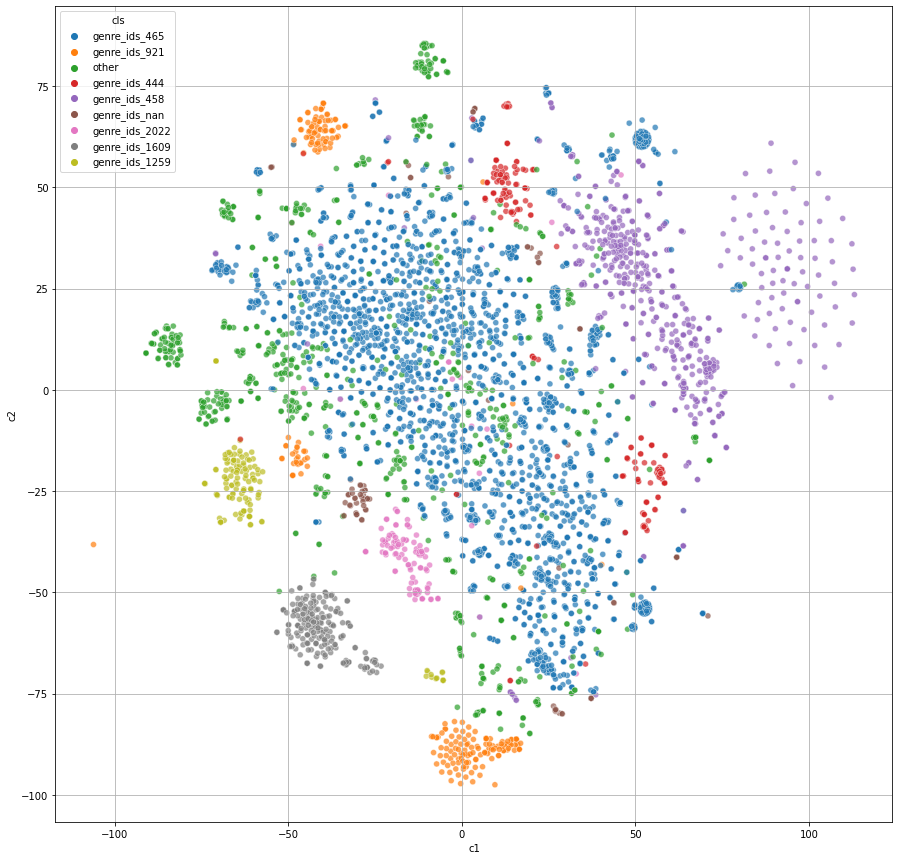

In [ ]:
vis_dssm_embeddings(data_train_pos, i2v, categorizer, reducer, 
                  item_fe_cols + [item_id_column], item_fe_cols,
                  cat_cols_to_change, SAMPLE_SIZE,
                  mappings, 8,
                  (15, 15), 0.7, "genre_ids")

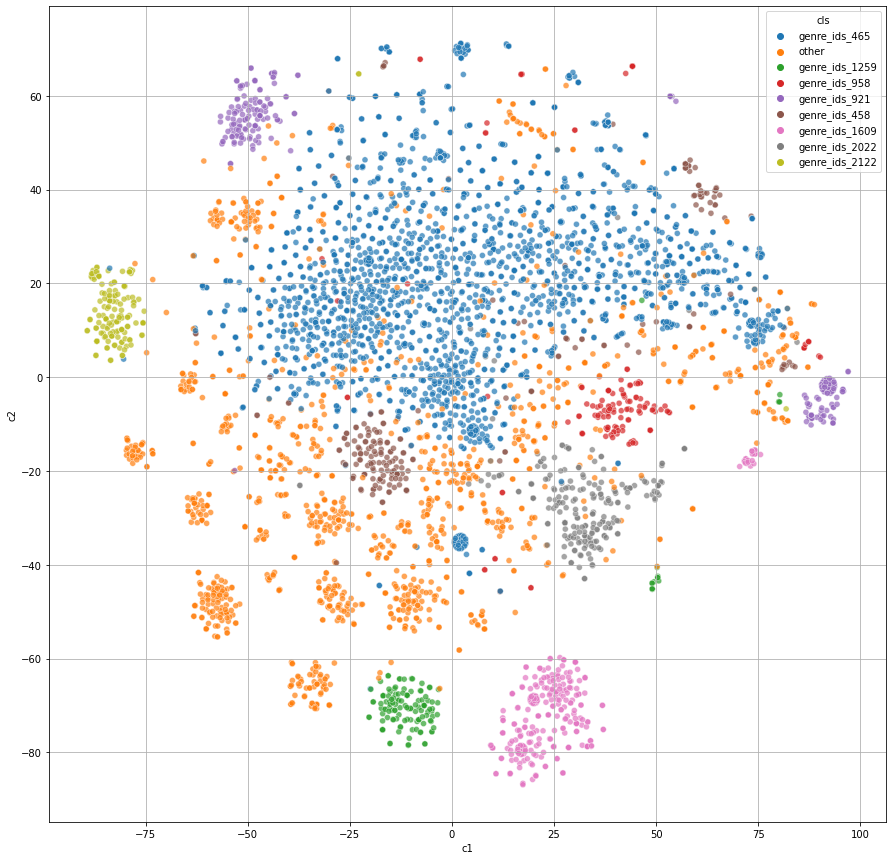

In [ ]:
vis_dssm_embeddings(cold_items_data, i2v, categorizer, reducer, 
                  item_fe_cols + [item_id_column], item_fe_cols,
                  cat_cols_to_change, SAMPLE_SIZE,
                  mappings, 8,
                  (15, 15), 0.7, "genre_ids")

#### UMAP method

Let's try different metrics in the UMAP class

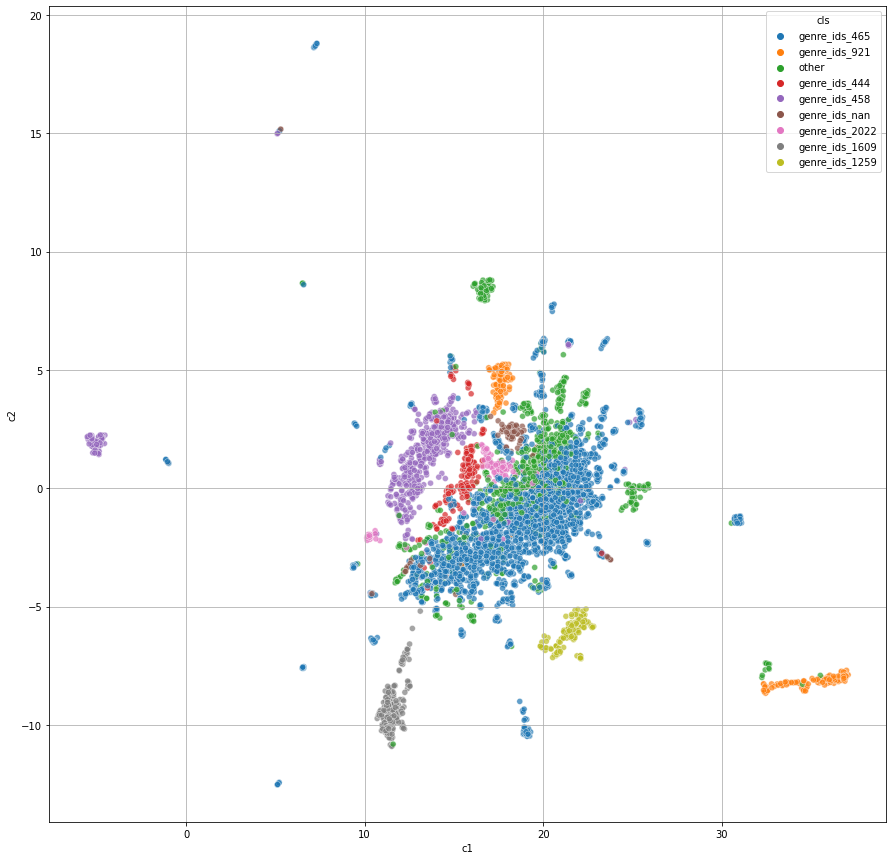

In [ ]:
reducer = umap.UMAP(n_neighbors=20,
                    min_dist=0.5,
                    n_components=2,
                    metric='euclidean',
                    random_state=42)
vis_dssm_embeddings(data_train_pos, i2v, categorizer, reducer, 
                    item_fe_cols + [item_id_column], item_fe_cols,
                    cat_cols_to_change, SAMPLE_SIZE,
                    mappings, 8,
                    (15, 15), 0.7, "genre_ids")

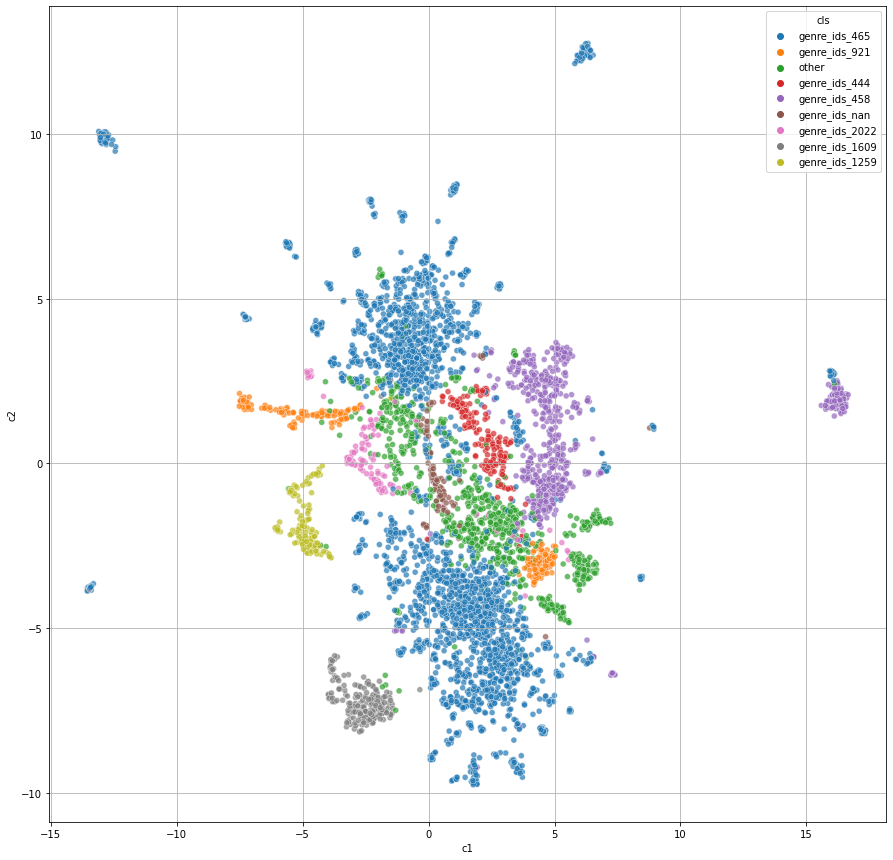

In [ ]:
reducer = umap.UMAP(n_neighbors=20,
                    min_dist=0.5,
                    n_components=2,
                    metric='cosine',
                    random_state=42)
vis_dssm_embeddings(data_train_pos, i2v, categorizer, reducer, 
                    item_fe_cols + [item_id_column], item_fe_cols,
                    cat_cols_to_change, SAMPLE_SIZE,
                    mappings, 8,
                    (15, 15), 0.7, "genre_ids")

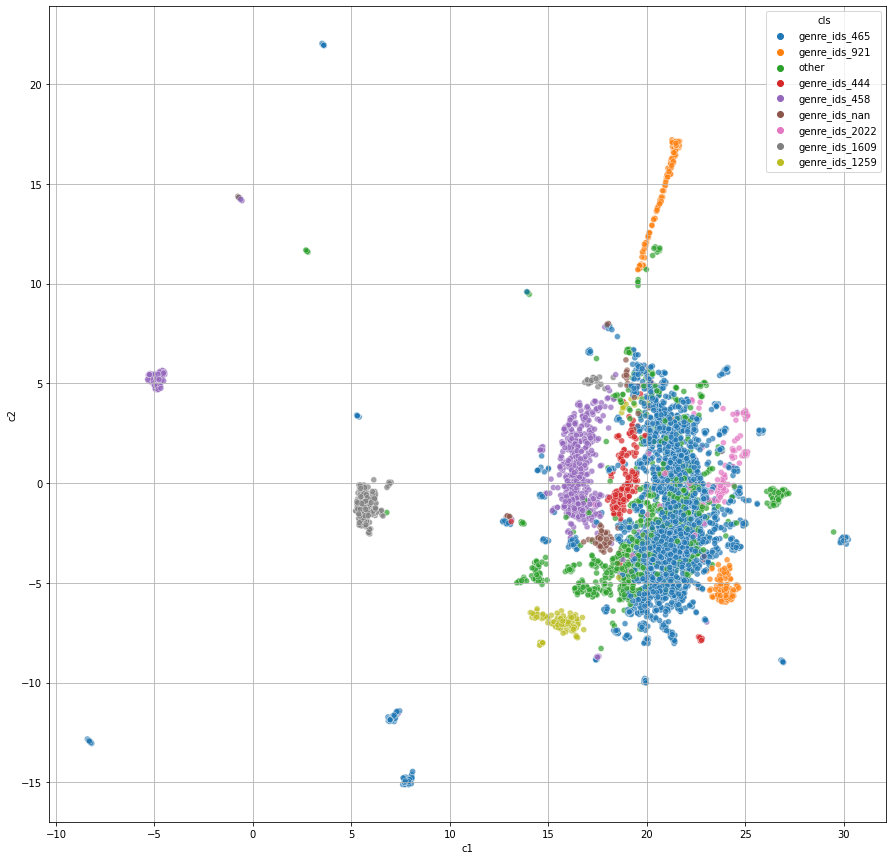

In [ ]:
reducer = umap.UMAP(n_neighbors=20,
                    min_dist=0.5,
                    n_components=2,
                    metric='manhattan',
                    random_state=42)
vis_dssm_embeddings(data_train_pos, i2v, categorizer, reducer, 
                    item_fe_cols + [item_id_column], item_fe_cols,
                    cat_cols_to_change, SAMPLE_SIZE,
                    mappings, 8,
                    (15, 15), 0.7, "genre_ids")

### So, you can see that we have some clusters for hot and cold items.  At the same time, some genres are very similar.

### Good luck in your experiments! :)